In [219]:
import numpy as np
import matplotlib.pyplot as plt

Problem 1

Before I do anything, I'll first import the data and plot it, to see what it looks like.

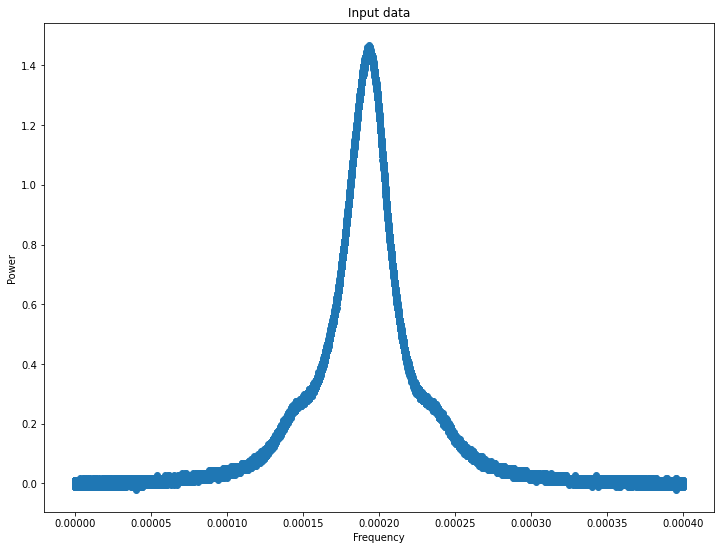

In [220]:
data = np.load('./sidebands.npz')
t = data['time']
d = data['signal']

plt.rcParams['figure.figsize'] = (12,9)
plt.scatter(t,d)
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Input data")
plt.show()

`get_chisq()` - A helper function that will compute the $\chi^2$ for a given model and parameters w.r.t the given data.

(a)

We would like to first try fitting a single lorentzian to the data, which hopefully captures the central peak. 

I first define the function `single_lorentzian` which is just my model function for the fit. I then define the function `analytic_derivatives_single_lorentzian` which returns an array with the gradients of my fit function with respect to the fit parameters, evaluated at each frequency $t$ (just as was done in class).

Next, I define the function `Newton` which does the Newton method to minimize $\chi^2 = \textbf{r}^T \cdot \textbf{N}^{-1} \cdot \textbf{r}$. Where $\textbf{r}$ is a vector of the residuals, and $\textbf{N}$ is the covariance matrix of the data. I will initially assume the covariance matrix to be identity (i.e., that the samples are all independent and uncorrelated) and use the approace from class, where I start from some initial guess of parameters $\textbf{m} = \textbf{m}_0$, and update $\textbf{m} \rightarrow \textbf{m} + \delta \textbf{m}$, with 

$(\textbf{A}_m^T \cdot \textbf{A}_m) \cdot \delta \textbf{m} = \textbf{A}_m^T \cdot \textbf{r}$

and 

$ [\textbf{A}_m]_{ij} = \frac{\partial r_i}{m_j} $ 

(this too was discussed in class, and most of my `Newton` function is basically copied from `newton.py` on the course git). The only important modification I made is to change the `for` loop to a `while` loop. My `Newton` function accepts a tolerance as an input, and the while loop runs as long as the largest (in absolute value) of all the $\delta \textbf{m}$ is larger than the tolerance, i.e., until $\delta \textbf{m}$ is "very small". I initialize $\delta \textbf{m}$ as an array of ones so that it is quite large and the while loop will run atleast once, but this is updated before the first actual step (inside the loop)

Finally, I play around with some initial guesses until I find some values that are reasonable to start with. I then call my functions and plot my results.

(b) Estimating noise in the parameters:

We have, by our assumption of normally distributed variables, near the minimum of $\chi^2(\textbf{m})$:

$ p(\textbf{y}|\textbf{m}) \propto \exp \bigg( - \frac{\chi^2(\textbf{m})}{2} \bigg) \approx \exp \bigg( - \frac{\chi^2(\overline{\textbf{m}})}{2} - \frac{1}{4} \delta \textbf{m} \cdot \nabla \nabla \chi^2(\overline{\textbf{m}}) \cdot \delta \textbf{m} \bigg)$

where $\overline{\textbf{m}}$ is the (hopefully global) minimum of $\chi^2$, so that $\nabla \chi^2 \approx 0$. We can use (from class) that:

$ \nabla \nabla \chi^2(\overline{\textbf{m}}) \approx 2 \textbf{A}_{\overline{m}}^T \textbf{N}^{-1} \textbf{A}_{\overline{m}} $, with $\textbf{A}_{\overline{m}}$ being the gradient (Jacobian) matrix evaluated at the minimum. Putting this into the expansion above, we see that the probability of a "fluctuation" about the minimum is also Gaussian with a covariance matrix: $ \textbf{N}_m \approx [\textbf{A}_{\overline{m}}^T \textbf{N}^{-1} \textbf{A}_{\overline{m}}]^{-1}$. We can then use, as a first approximation:

$n = \text{mean}(({\text{model} - \text{data}})^2)$

$ \textbf{N}^{-1} = \text{diag}(\frac{1}{n}, \frac{1}{n}, \frac{1}{n} ,....)$

to estimate the errors of the parameters using the square root of the diagonal elements of $\textbf{N}_m$

Since different models will give different noise estimates, I will also include a computation of $\chi^2$ assuming noise=1 to see how the different models compare to one another.

In [221]:
def get_chisq(model, t, p, noise = 1, data=d):
    return np.sum((model(t,p)-data)**2/noise**2)

def get_pcov(model, t, p_bestfit, derivative, data=d):
    noise = np.mean((data - model(t,p_bestfit))**2)
    A = derivative(model,t,p_bestfit)
    pcov = np.linalg.inv(A.T @ A) * noise
    return pcov

def single_lorentzian(t,p):
    return p[0]/(1 + (t-p[1])**2/p[2]**2)

#this does not need model as an input, but the numerical version does, and I'd like to use the same Newton fn later
def analytic_derivative(model,t,p):
    grad = np.zeros((len(t), len(p)))
    den = (1 + (t-p[1])**2/p[2]**2)
    grad[:,0] = 1/den
    grad[:,1] = 2 * p[0] * (t-p[1])/(p[2]**2 * den**2)
    grad[:,2] = 2 * p[0] * (t-p[1])**2 / (p[2]**3 * den**2)
    return grad

def Newton(model, t, d, p0, derivative, tol=1E-8):
    dp = 1*np.ones(len(p0))
    p = p0.copy()

    while np.abs(np.max(dp))>tol:
        pred = model(t,p)
        grad = derivative(model, t , p)
        r = d - pred
        err=(r**2).sum()
        r=np.matrix(r).transpose()
        grad=np.matrix(grad)

        lhs=grad.transpose()*grad
        rhs=grad.transpose()*r
        dp=np.linalg.pinv(lhs)*(rhs)
        for jj in range(p.size):
            p[jj]=p[jj]+dp[jj]
    return p

# initial guess
p0 = np.array([1.4, 0.000195, 0.000015])


fitp_analytic = Newton(single_lorentzian, t, d, p0, analytic_derivative)


pcov = get_pcov(single_lorentzian, t, fitp_analytic, analytic_derivative)

noise = np.mean((d - single_lorentzian(t,fitp_analytic))**2)

print("Fit parameters: ")
print("a = ", fitp_analytic[0]," +/- ", np.sqrt(pcov[0,0]))
print("t0 = ", fitp_analytic[1]," +/- ", np.sqrt(pcov[1,1]))
print("w = ", fitp_analytic[2]," +/- ", np.sqrt(pcov[2,2]))
print("fit chi-squared = ", get_chisq(single_lorentzian, t, fitp_analytic, np.sqrt(noise)))
print("initial chi-squared = ", get_chisq(single_lorentzian, t, p0, np.sqrt(noise)))

Fit parameters: 
a =  1.4228106431876597  +/-  0.000425479034683926
t0 =  0.00019235865056641918  +/-  5.358345845483536e-09
w =  1.7923691738228822e-05  +/-  7.588097645872553e-09
fit chi-squared =  99999.99999999996
initial chi-squared =  722420.7016917687


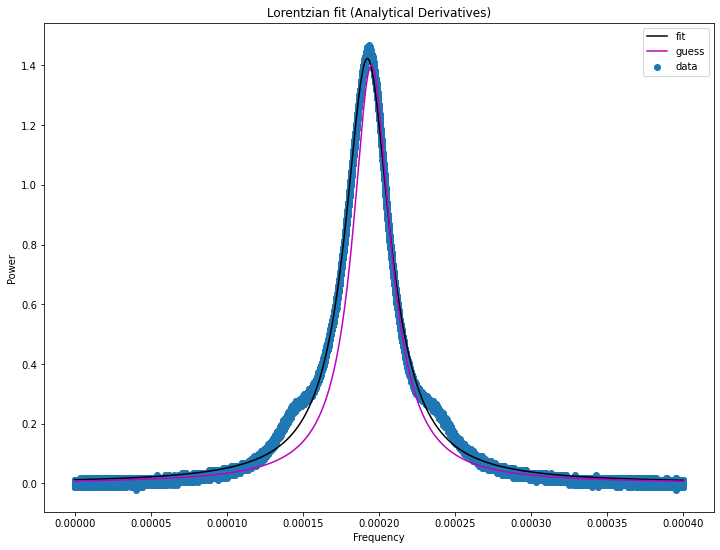

In [222]:
plt.plot(t, single_lorentzian(t,fitp_analytic), c='k', label='fit')
plt.plot(t, single_lorentzian(t,p0), c='m', label = 'guess')
plt.scatter(t,d, label='data')
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Lorentzian fit (Analytical Derivatives)")
plt.show()

(c) For this part, I simply need to replace the analytic derivatives with numerical ones. For this part, I use a central difference scheme: $\frac{df}{dp} \approx \frac{f(x+dp) - f(x-dp)}{2dp}$ with $dp = (10^{-16})^{1/3}$ which was close to the ideal value for this scheme. For simplicity, and for efficiency, I did not try to make a variable $dp$ scheme here. This seems to work fine. The function calls are then basically the same as before, but I replace `analytic_derivative` with `num_der` which does the numerical differentiation.

In [223]:
def num_der(model, t, p):
    grad = np.zeros((len(t), len(p)))
    dp = (1E-16)**(1/3)
    for i in range(len(p)):
        p_left = p.copy()
        p_left[i] = p[i]-dp
        p_right = p.copy()
        p_right[i] = p[i] + dp
        grad[:,i] = (model(t, p_right) - model(t, p_left))/2/dp
    return grad

# initial guess (same as before)
p0 = np.array([1, 0.0002, 0.00002])

fitp_num = Newton(single_lorentzian, t,d,p0, num_der, 1E-8)

n1 = np.mean((single_lorentzian(t,fitp_num) - d)**2)

pcov = get_pcov(single_lorentzian, t, fitp_analytic, num_der)

print("Fit parameters: ")
print("a = ", fitp_num[0]," +/- ", np.sqrt(pcov[0,0]))
print("t0 = ", fitp_num[1]," +/- ", np.sqrt(pcov[1,1]))
print("w = ", fitp_num[2]," +/- ", np.sqrt(pcov[2,2]))
print("fit chi-squared = ", get_chisq(single_lorentzian, t, fitp_num, np.sqrt(n1)))
print("initial chi-squared = ", get_chisq(single_lorentzian, t, p0, np.sqrt(n1)))

Fit parameters: 
a =  1.4231036916776922  +/-  0.0004330038930468543
t0 =  0.0001923345811544917  +/-  5.535104228085522e-09
w =  1.7916281532576344e-05  +/-  7.722285832586922e-09
fit chi-squared =  100000.0
initial chi-squared =  2984422.057330751


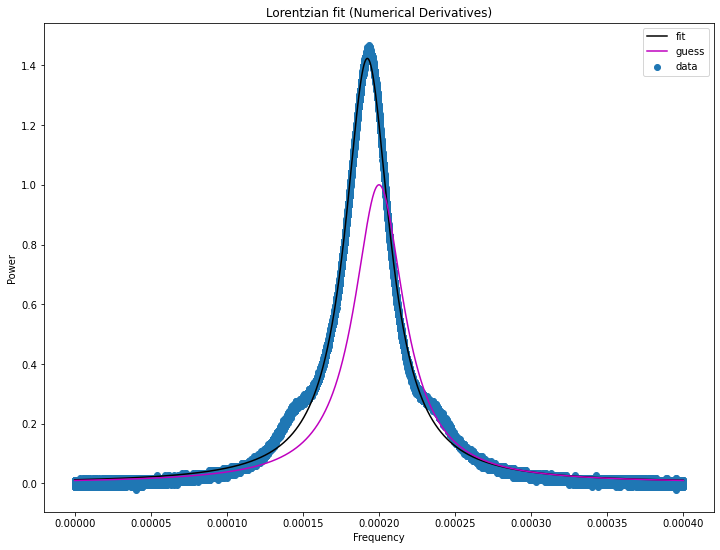

In [224]:
plt.plot(t, single_lorentzian(t,fitp_num), c='k', label='fit')
plt.plot(t, single_lorentzian(t,p0), c='m', label = 'guess')
plt.scatter(t,d, label='data')
plt.legend()
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Lorentzian fit (Numerical Derivatives)")
plt.show()

In [225]:
print("a_new - a_old = ", fitp_num[0] - fitp_analytic[0])
print("t0_new - t0_old = ", fitp_num[1] - fitp_analytic[1])
print("w_new - w_old = ", fitp_num[2] - fitp_analytic[2])

a_new - a_old =  0.0002930484900325325
t0_new - t0_old =  -2.406941192748457e-08
w_new - w_old =  -7.410205652477725e-09


The answers are statistically significantly different, but only very slightly. The change in $\chi^2<<1$, and the parameter values are all within 1 sigma of each other, except for `t0` which does appear to be statistically different (by around 5 sigma).

(d) Now we repeat the above procedure but with a new fit function with more parameters (it is now a sum of lorentzians). All I do here is change my fit function and remake the function calls from above with this new fit function, and the print and plot the results.

In [226]:
def sum_of_lorentzians(t,p):
    term1 = p[0]/(1 + ((t-p[3])**2/p[5]**2))
    term2 = p[1]/(1 + ((t-p[3] + p[4])**2/p[5]**2))
    term3 = p[2]/(1 + ((t-p[3] - p[4])**2/p[5]**2))
    return term1 + term2 + term3


p0 = np.array([1.4, 0.1, 0.1, 0.000194, 5E-5, 0.000015])

fitp_num2 = Newton(sum_of_lorentzians,t,d,p0, num_der,1E-8)

pcov = get_pcov(sum_of_lorentzians, t, fitp_num2, num_der)

n2 = np.mean((d - sum_of_lorentzians(t,fitp_num2))**2)

print("Fit parameters: ")
print("a = ",fitp_num2[0]," +/- ", np.sqrt(pcov[0,0]))
print("b = ",fitp_num2[1]," +/- ", np.sqrt(pcov[1,1]))
print("c = ",fitp_num2[2]," +/- ", np.sqrt(pcov[2,2]))
print("t0 = ",fitp_num2[3]," +/- ", np.sqrt(pcov[3,3]))
print("dt = ",fitp_num2[4]," +/- ", np.sqrt(pcov[4,4]))
print("w = ",fitp_num2[5]," +/- ", np.sqrt(pcov[5,5]))
print("Fit chi-squared = ", get_chisq(sum_of_lorentzians, t, fitp_num2, np.sqrt(n2)))
print("Initial chi-squared = ", get_chisq(sum_of_lorentzians, t, p0, np.sqrt(n2)))

Fit parameters: 
a =  1.44256383765942  +/-  0.0002728916025634804
b =  0.10338039272528377  +/-  0.00025521215233015933
c =  0.06490154144791264  +/-  0.0002494518552435846
t0 =  0.00019255509497519483  +/-  3.3200630380175075e-09
dt =  4.4466442687289736e-05  +/-  3.994373440586406e-08
w =  1.6073067734482408e-05  +/-  5.762686038296957e-09
Fit chi-squared =  99999.99999999997
Initial chi-squared =  749333.3798080876


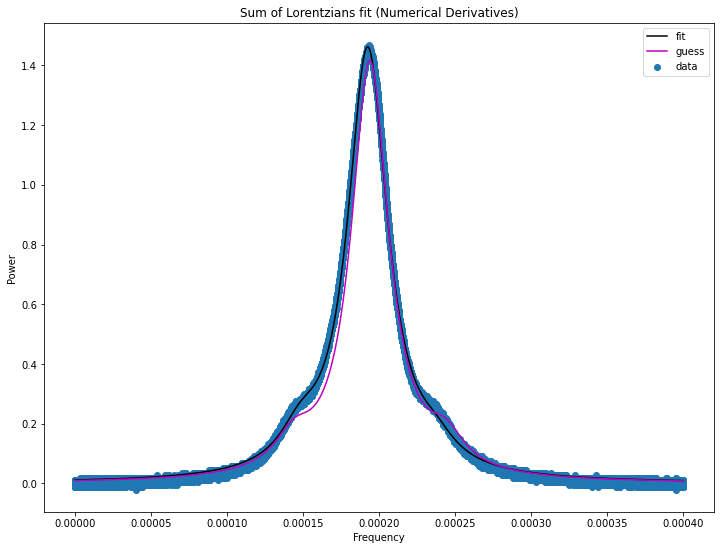

In [227]:
plt.plot(t, sum_of_lorentzians(t,fitp_num2), c='k', label='fit')
plt.plot(t, sum_of_lorentzians(t,p0), c='m', label = 'guess')
plt.scatter(t, d, label='data')
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Sum of Lorentzians fit (Numerical Derivatives)")
plt.legend()
plt.show()

Let's now look at the residuals from this last fit, which seems to be the best of the lot, although apparently not by much.

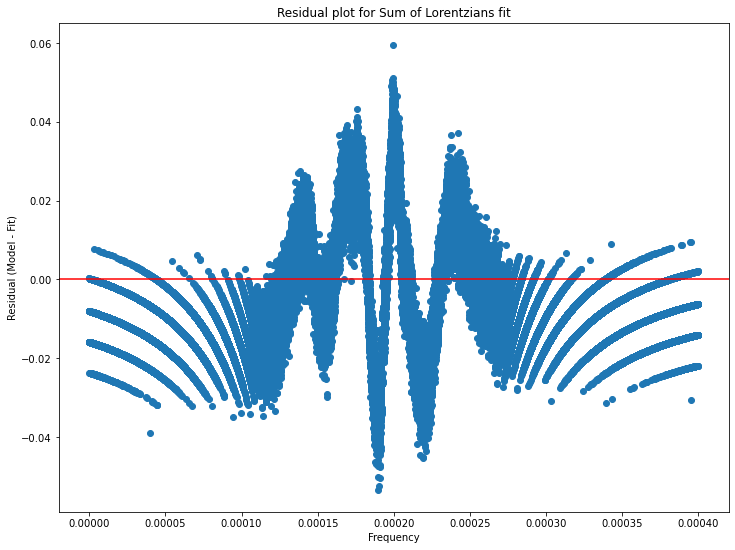

In [228]:
res = d - sum_of_lorentzians(t,fitp_num2)
plt.scatter(t, res)
plt.axhline(0, c='r')
plt.xlabel("Frequency")
plt.ylabel("Residual (Model - Fit)")
plt.title("Residual plot for Sum of Lorentzians fit")
plt.show()

Yikes! Okay, the data is $\textit{definitely}$ not independent and uncorrelated. There is a clear oscillatory trend in the residual and the points are certainly not randomly distributed about the $y=0$ line. This means that the error bars we got by assuming that our data was independent and uncorrelated with the same variance is quite incorrect. I am not sure if that means that our fit function is necessarily incorrect though. However, I believe that the model might not be a complete description of the data because we haven't done a very good job with estimating the data covariance matrix $\textbf{N}$. If we were able to do a more sophisticated analysis of that, we might have a much better description of the data.

(f) Generating some realizations of the parameter errors.

I use the Cholesky decomposition method here to draw the required random samples. The basic problem here is that we have some covariance matrix and would like to generate random instances of samples drawn from the gaussian PDF with this covariance matrix. A simple way to do this is to simply diagonalize the covariance matrix (which by definition must be square and positive definite) through a rotation and then use the diagonal elements of this diagonal matrix as variances to draw a vector of samples using something like `np.random.randn()` and then do an inverse rotation of this sample to get back to the original basis we started with. 

The "pro gamer move" version of this is to diagonalize the covariance matrix in such a way that the new diagonalized matrix is just the identity matrix (this is, according to Jon, always possible for positive definite matrices). This is the Cholesky decomposition. This way we can draw samples from a standard normal distribution and then rotate back to our original basis. My function `get_step(pcov)` implements this and returns a random sample of parameter errors. We could also use `np.random.multivariate_normal()`, which apparently does the same thing. 

I use this to draw 1000 random samples for the parameter errors. I add those to my original best_fit paramters. I compute the $\chi^2$ for these new samples and see how they compare to the old. Realistically I would (very crudely) expect that the $\chi^2$ change on the order of magnitude of:

$ \delta \chi^2 \approx \bigg< \delta \textbf{m}^T \textbf{N}_m^{-1} \delta \textbf{m} \bigg> \approx \sqrt{\bigg< (\delta \textbf{m}^T)^2 \bigg>} \textbf{N}_m^{-1} \sqrt{\bigg< (\delta \textbf{m})^2 \bigg>} $

In [238]:
def get_step(pcov):
    L = np.linalg.cholesky(pcov)
    dm = L @ (np.random.randn(np.shape(pcov)[0]))
    return dm

del_m = np.sqrt(np.diag(pcov))
print("Order of magnitude estimate for rms difference in chi-squared: ", del_m.T @ np.linalg.inv(pcov) @ del_m)

nsamples = 1000

newp = np.zeros((nsamples+1, len(p0)))
newp[0,:] = fitp_num2 
chisq = [get_chisq(sum_of_lorentzians, t, fitp_num2, np.sqrt(n3))]

for i in range(1,nsamples+1):
    #newp[i,:] = fitp_num2 + np.random.multivariate_normal(np.zeros(len(p0)), cov = pcov)
    newp[i,:] = fitp_num2 + get_step(pcov)
    chisq.append(get_chisq(sum_of_lorentzians, t, newp[i,:], np.sqrt(n3)))

n3 = np.mean((sum_of_lorentzians(t,fitp_num2) - d)**2)

print("Original (Unperturbed) chi-squared: ", chisq[0])
print("RMS difference of perturbed chi-squared's:\n", np.sqrt(np.mean((chisq[1:] - chisq[0])**2)))


Order of magnitude estimate for rms difference in chi-squared:  24.741096346971098
Original (Unperturbed) chi-squared:  99999.99999999997
RMS difference of perturbed chi-squared's:
 19.523988352303355


The $\chi^2$ do indeed seem to be changing on the expected order of magnitude, which is quite reasonable. So the uncertainties derived from Newton's method are not terrible, and any shortcomings of the model are because our model itself is incomplete, and not because of the way we did our fit.

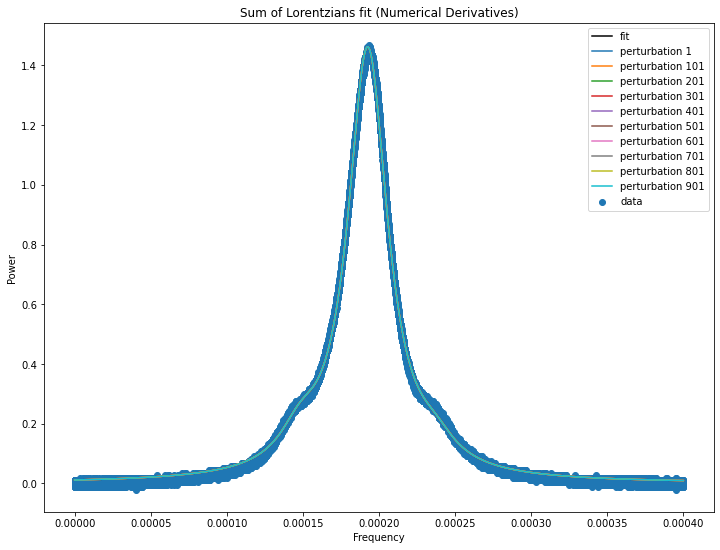

In [230]:
plt.clf()
plt.plot(t, sum_of_lorentzians(t,newp[0,:]), c='k', label='fit')
for i in range(1, nsamples+1, 100):
    plt.plot(t, sum_of_lorentzians(t,newp[i,:]), label = 'perturbation {}'.format(i))

plt.scatter(t, d, label='data')
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Sum of Lorentzians fit (Numerical Derivatives)")
plt.legend()
plt.show()

It is almost impossible to even tell these various fits apart. This kind of makes sense considering how small the error bars in each of our parameters are. This isn't necessarily correct either, since I would expect there to be more leeway in the fits near the tails of the data since the noise there definitely seems to be larger. Once again, I think we would need to better estimate the correlations in the data to do a better job with the fit.

MCMC

The code below is practically copy pasted from the code discussed in class which some very minor modifications. The idea is simple. I plan to run 30000 random walk steps for my simulation. I start with some initial guesses (same as the ones I used earlier). I then initialize my chain with my initial guesses and start a list with the initial $\chi^2$. I assume that the noise I had earlier for the data is wrong, and I go back to assuming that the variance in the data is simply uniform and equal to 1. I however use the previous results for the covariance matrix. Then I start my chain and at each iteration, I take a trial step generated using the covariance matrix from my previous fit (I had to scale this by a factor of 5 to make my chain converge faster, this isn't too bad since we already underestimated our parameter errors anyway) and compute the new $\chi^2$ for this trial step. If the $\chi^2$ is lower, I take the step, and if it is greater I use the acceptance probability as discussed in class to decide whether to take the step or not. I keep appending the $\chi^2$ for each step and plot it as one of the convergence indicators.

<ipython-input-231-9de4859d1f7c>:19: RuntimeWarning: overflow encountered in exp
  accept = np.exp(-0.5*(chisq_diff))


<function matplotlib.pyplot.show(close=None, block=None)>

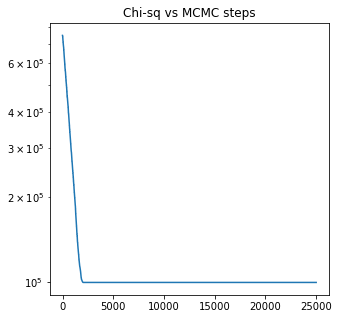

In [231]:
nstep = 25000

p0 = np.array([1.4, 0.1, 0.1, 0.000194, 5E-5, 0.000015])
noise = np.sqrt(np.mean((d - sum_of_lorentzians(t, fitp_num2))**2))
chain = np.zeros([nstep, len(p0)])
chain[0,:] = p0
pcov = get_pcov(sum_of_lorentzians, t, fitp_num2, num_der)
chisq_list = []
chisq_old = get_chisq(sum_of_lorentzians, t, p0, noise)
chisq_list.append(chisq_old)

for i in range(1,nstep):
    
    pp = chain[i-1,:] + get_step(pcov)
    chisq_new = get_chisq(sum_of_lorentzians, t, pp, noise)
    chisq_diff = chisq_new - chisq_old
    
    try:
        accept = np.exp(-0.5*(chisq_diff))

        if accept>np.random.rand(1):
            chain[i,:] = pp
            chisq_old = chisq_new
            chisq_list.append(chisq_old)

        else:
            chain[i,:] = chain[i-1,:]
            chisq_list.append(chisq_old)
    except:
        chain[i,:] = chain[i-1,:]
        chisq_list.append(chisq_old)
        

plt.rcParams['figure.figsize'] = (5,5)
plt.clf()
plt.semilogy(range(nstep), chisq_list)
plt.title("Chi-sq vs MCMC steps")
plt.show

<Figure size 360x360 with 0 Axes>

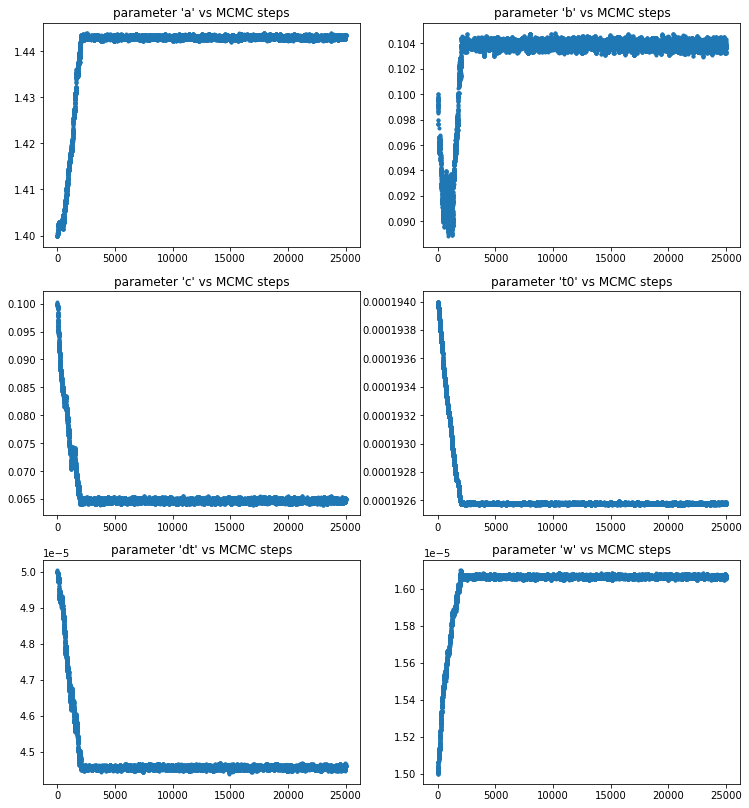

In [232]:
plt.clf()

plt.rcParams['figure.figsize'] = (12.5,14)
fig, axes = plt.subplots(3,2)
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]
ax5 = axes[2,0]
ax6 = axes[2,1]

ax1.plot(range(nstep), chain[:,0], '.')
ax1.set_title("parameter 'a' vs MCMC steps")

ax2.plot(range(nstep), chain[:,1], '.')
ax2.set_title("parameter 'b' vs MCMC steps")

ax3.plot(range(nstep), chain[:,2], '.')
ax3.set_title("parameter 'c' vs MCMC steps")

ax4.plot(range(nstep), chain[:,3], '.')
ax4.set_title("parameter 't0' vs MCMC steps")

ax5.plot(range(nstep), chain[:,4], '.')
ax5.set_title("parameter 'dt' vs MCMC steps")

ax6.plot(range(nstep), chain[:,5], '.')
ax6.set_title("parameter 'w' vs MCMC steps")

plt.show()

Let's zoom in on the flat portion of the above plots to see if the random walker has properly sampled the space.

<Figure size 900x1008 with 0 Axes>

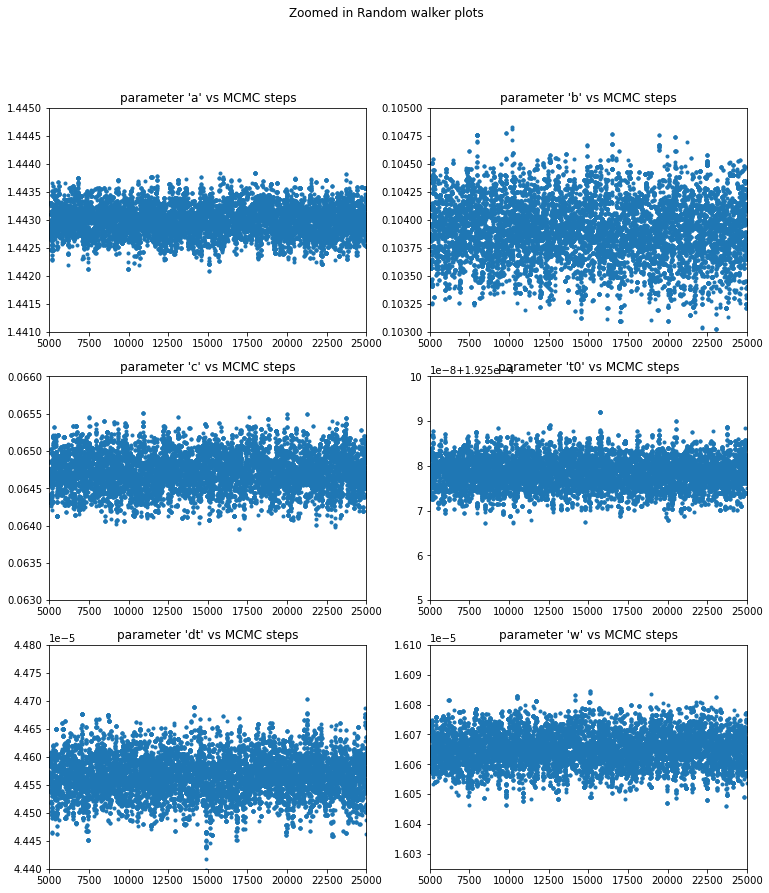

In [233]:
plt.clf()
plt.rcParams['figure.figsize'] = (12.5,14)
fig, axes = plt.subplots(3,2)
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]
ax5 = axes[2,0]
ax6 = axes[2,1]

ax1.plot(range(nstep), chain[:,0], '.')
ax1.set_title("parameter 'a' vs MCMC steps")
ax1.set_xlim(5000,25000)
ax1.set_ylim(1.441, 1.445)

ax2.plot(range(nstep), chain[:,1], '.')
ax2.set_title("parameter 'b' vs MCMC steps")
ax2.set_xlim(5000,25000)
ax2.set_ylim(0.103, 0.105)

ax3.plot(range(nstep), chain[:,2], '.')
ax3.set_title("parameter 'c' vs MCMC steps")
ax3.set_xlim(5000,25000)
ax3.set_ylim(0.063, 0.066)

ax4.plot(range(nstep), chain[:,3], '.')
ax4.set_title("parameter 't0' vs MCMC steps")
ax4.set_xlim(5000,25000)
ax4.set_ylim(0.00019255, 0.00019260)

ax5.plot(range(nstep), chain[:,4], '.')
ax5.set_title("parameter 'dt' vs MCMC steps")
ax5.set_xlim(5000,25000)
ax5.set_ylim(4.44E-5, 4.48E-5)

ax6.plot(range(nstep), chain[:,5], '.')
ax6.set_title("parameter 'w' vs MCMC steps")
ax6.set_xlim(5000,25000)
ax6.set_ylim(1.6025E-5, 1.61E-5)

fig.suptitle("Zoomed in Random walker plots")
plt.show()

For each parameter, there is no obvious increasing or decreasing trend, they seem to be randomly distributed about some average values as we would expect, and it appears that the random walker is spending enough time at the relevant parameter values so that this plot is somewhat representative of the average behaviour of the walker. This is why I think my chain has converged (or has atleast gotten very very close to it). My initial guesses were somewhat off, so there is a burn-in time. I just chose 5000 random walk steps onwards as a decent place to start computing the averages and standard deviations of the parameters (I did play around with this a little bit and it did not change my results appreciably). I also look at the power spectra next as another verification of convergence.

<Figure size 900x1008 with 0 Axes>

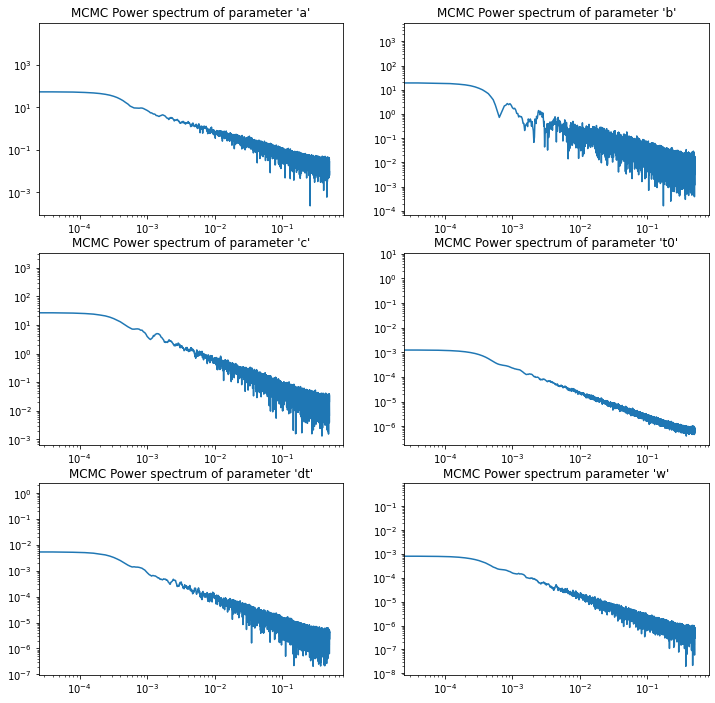

In [234]:
freq = np.fft.rfftfreq(nstep)
fft0 = np.abs(np.fft.rfft(chain[:,0]))
fft1 = np.abs(np.fft.rfft(chain[:,1]))
fft2 = np.abs(np.fft.rfft(chain[:,2]))
fft3 = np.abs(np.fft.rfft(chain[:,3]))
fft4 = np.abs(np.fft.rfft(chain[:,4]))
fft5 = np.abs(np.fft.rfft(chain[:,5]))

plt.clf()
plt.rcParams['figure.figsize'] = (12,12)
fig, axes = plt.subplots(3,2)
ax1 = axes[0,0]
ax2 = axes[0,1]
ax3 = axes[1,0]
ax4 = axes[1,1]
ax5 = axes[2,0]
ax6 = axes[2,1]

ax1.loglog(freq, fft0)
ax1.set_title("MCMC Power spectrum of parameter 'a'")

ax2.loglog(freq, fft1)
ax2.set_title("MCMC Power spectrum of parameter 'b'")

ax3.loglog(freq, fft2)
ax3.set_title("MCMC Power spectrum of parameter 'c'")

ax4.loglog(freq, fft3)
ax4.set_title("MCMC Power spectrum of parameter 't0'")

ax5.loglog(freq, fft4)
ax5.set_title("MCMC Power spectrum of parameter 'dt'")

ax6.loglog(freq, fft5)
ax6.set_title("MCMC Power spectrum parameter 'w'")

plt.show()

The power spectrum also seems to indicate that the chain has converged, since the low-k behaviour is quite flat for the parameters.

In [235]:
fitp_mcmc = np.mean(chain[5000:,:], axis=0)
fitp_mcmc_errs = np.std(chain[5000:,:], axis=0)
noise_mcmc = np.mean((sum_of_lorentzians(t,fitp_mcmc) - d)**2)
noise_old = np.mean((sum_of_lorentzians(t,fitp_num2) - d)**2)

print("Fit parameters for MCMC: ")
print("a = ",fitp_mcmc[0]," +/- ", fitp_mcmc_errs[0])
print("b = ",fitp_mcmc[1]," +/- ", fitp_mcmc_errs[1])
print("c = ",fitp_mcmc[2]," +/- ", fitp_mcmc_errs[2])
print("t0 = ",fitp_mcmc[3]," +/- ", fitp_mcmc_errs[3])
print("dt = ",fitp_mcmc[4]," +/- ", fitp_mcmc_errs[4])
print("w = ",fitp_mcmc[5]," +/- ", fitp_mcmc_errs[5])
print("chi-squared = ", np.mean(chisq_list[5000:]))
print("MCMC noise estimate = ", noise_mcmc)

print("\n Previous Fit parameters: ")
print("a = ",fitp_num2[0]," +/- ", np.sqrt(pcov[0,0]))
print("b = ",fitp_num2[1]," +/- ", np.sqrt(pcov[1,1]))
print("c = ",fitp_num2[2]," +/- ", np.sqrt(pcov[2,2]))
print("t0 = ",fitp_num2[3]," +/- ", np.sqrt(pcov[3,3]))
print("dt = ",fitp_num2[4]," +/- ", np.sqrt(pcov[4,4]))
print("w = ",fitp_num2[5]," +/- ", np.sqrt(pcov[5,5]))
print("chi-squared = ", get_chisq(sum_of_lorentzians, t, fitp_num2, np.sqrt(noise_old)))
print("Old noise estimate = ", noise_old)

Fit parameters for MCMC: 
a =  1.4429903791602408  +/-  0.0002562478402453431
b =  0.10390626029215293  +/-  0.00026262801806782056
c =  0.06472928434898918  +/-  0.00023888186787132012
t0 =  0.00019257844742370117  +/-  3.2833344218290005e-09
dt =  4.4566450851814615e-05  +/-  3.519655056818734e-08
w =  1.6065140925977847e-05  +/-  5.562775374039109e-09
chi-squared =  99935.15877419688
MCMC noise estimate =  0.00021247274580806204

 Previous Fit parameters: 
a =  1.44256383765942  +/-  0.0002728916025634804
b =  0.10338039272528377  +/-  0.00025521215233015933
c =  0.06490154144791264  +/-  0.0002494518552435846
t0 =  0.00019255509497519483  +/-  3.3200630380175075e-09
dt =  4.4466442687289736e-05  +/-  3.994373440586406e-08
w =  1.6073067734482408e-05  +/-  5.762686038296957e-09
chi-squared =  99999.99999999997
Old noise estimate =  0.00021262338304690412


As it turns out, the errors we got for the parameters assuming Newton's method were not so bad. They did change, but only very slightly (correct order of magnitude). MCMC gives roughly the same results, although the MCMC fit does have a statistically significantly lower $\chi^2$ so it did a bit better than Newton's method. 

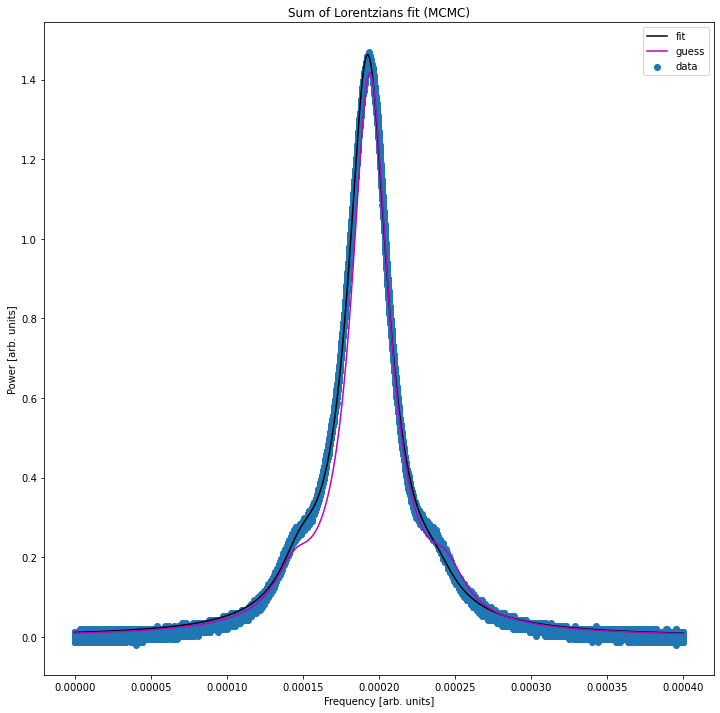

In [239]:
plt.plot(t, sum_of_lorentzians(t,fitp_mcmc), c='k', label='fit')
plt.plot(t, sum_of_lorentzians(t,p0), c='m', label = 'guess')
plt.scatter(t, d, label='data')
plt.xlabel("Frequency [arb. units]")
plt.ylabel("Power [arb. units]")
plt.title("Sum of Lorentzians fit (MCMC)")
plt.legend()
plt.show()

(h) To correctly convert our units to GHz, we need to find $\alpha$ such that in our fit function notation:

$ 9 \text{ GHz} = \alpha dt \implies \alpha = \frac{9}{dt}$,

and so the width (which has the same units as $dt$) in GHz would be:

$ w' = \alpha w = \frac{9}{dt} w$

This value is computed below.

In [240]:
print("Actual width of cavity resonance is = ", 9 * fitp_mcmc[5]/fitp_mcmc[4], "GHz")

Actual width of cavity resonance is =  3.2442850074500265 GHz


i.e. the sidebands are about 3 peak widths away from the central peak (so they are sufficiently resolved that our initial fit with a single lorentzian could not have been right).